In [1]:
#| default_exp analytic_curves
from nbdev.showdoc import *
import numpy as np
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
from sympy import *
from typing import Tuple
from functools import partial
import diffusion_curvature
from diffusion_curvature.core import plot_3d, diffusion_matrix, gaussian_kernel
from diffusion_curvature.curves import *
from diffusion_curvature.datasets import *
# Reload any changes made to external files
%load_ext autoreload
%autoreload 2

# Analytic form of the Local Diffusion Entropy

Ahmed and Gokhale (cited by Wikipedia) have proven that the *differential entropy* of the multivariate gaussian is 

$$
\frac{k}{2}+\frac{k}{2} \ln (2 \pi)+\frac{1}{2} \ln (|\boldsymbol{\Sigma}|)
$$

where $k$ is the dimension of the space, and $|\Sigma|$ is the determinant of the covariance matrix. Does this match our computation about?

Note that in the heat kernel, the bandwidth is uniform throughout all dimensions (i.e. is a diagonal matrix), with determinant equal to $2^k t^k$, rendering this

$$
\frac{d}{2}+\frac{d}{2} \ln (2 \pi)+\frac{1}{2} \ln (2^d t^d)
$$

In [2]:
def differential_entropy_of_euclidean_heat_kernel(dim, t, scaling_factor=1, time_offset=0):
    """Accepts vectorized t as input"""
    return dim/2 + (dim/2)*(np.log(2*np.pi))+(1/2)*np.log(2**dim*(scaling_factor*(t)+time_offset)**dim)

# Automatic Scaling by the entropy invariance principle

In [3]:
import numpy as np
def time_of_entropy(h, dimension):
    """Gives the time that would produce the specified entropy"""
    return ((np.exp(2*(h - dimension/2 - (dimension/2)*np.log(2*np.pi))))/(2**dimension))**(1/dimension)

def autoscale_by_entropy(
        target_dist:np.ndarray, # the curvature curve to fit 
        dimension:int # the manifold's intrinsic dimension
        ):
    h_start = target_dist[0]
    h_stop = target_dist[-1]
    t_start = time_of_entropy(h_start,dimension=dimension)
    t_stop = time_of_entropy(h_stop,dimension=dimension)
    scaling_factor = (t_stop - t_start)/(len(target_dist) - 1)
    scaled_differential_entropy = partial(differential_entropy_of_euclidean_heat_kernel,scaling_factor = scaling_factor, time_offset = t_start)
    return scaled_differential_entropy, scaling_factor, t_start

In [4]:
h_test = 6
t_test = time_of_entropy(h_test,dimension=2)
assert h_test == differential_entropy_of_euclidean_heat_kernel(dim=2,t=t_test)

Here are some discretely sampled distributions, matched to this analytic curve by this simple scaling method.

In [18]:
def plot_scaled_entropies(X, idx = 0, dim=2, dataset_name = "", **kwargs):
    entropies = rate_of_change_of_entropy(X, **kwargs)
    entropies_of_point = entropies[idx]
    scaled_diffh, scale_factor, start_t = autoscale_by_entropy(entropies_of_point, dimension=dim)
    ts = np.arange(len(entropies_of_point))
    fitted_analytic = scaled_diffh

    plt.plot(ts, fitted_analytic(t=ts, dim=2), label="continuous")
    plt.plot(ts, entropies_of_point, label=f"discrete {dataset_name}")
    plt.xlabel("time (scaled)")
    plt.ylabel("Entropy of Diffusion")
    plt.title(f"Curvature Curves: Fitted to {dataset_name}")
    plt.legend()

    return {
        "fitted analytic":fitted_analytic,
        "scale factor":scale_factor,
        "start t":start_t,
        "entropies of point":entropies_of_point
    }

0it [00:00, ?it/s]

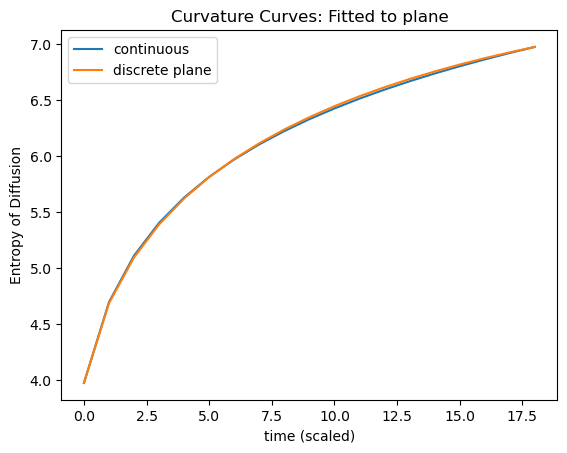

In [19]:
X_plane = plane(2000)
deets = plot_scaled_entropies(X_plane, dataset_name="plane", max=20)

0it [00:00, ?it/s]

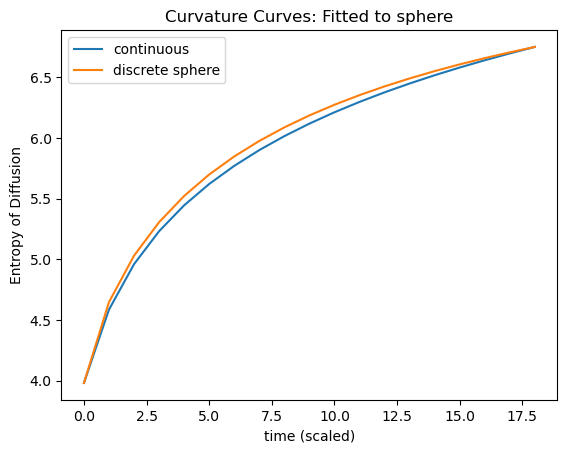

In [20]:
deets_sphere = plot_scaled_entropies(X_sphere, dataset_name="sphere", max=20)

0it [00:00, ?it/s]

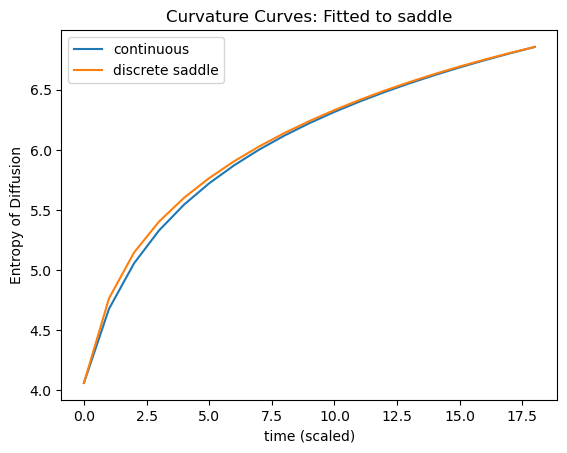

In [21]:
deets_saddle = plot_scaled_entropies(X_saddle, dataset_name="saddle",max=20)